## Import dependencies

In [16]:
import pandas as pd
import seaborn as sns
import time

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier, BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

import joblib

## Read data

In [31]:
X_train = pd.read_csv("../data/X_train_3.csv",header=[0,1],index_col=0)
X_test = pd.read_csv("../data/X_test_3.csv",header=[0,1],index_col=0)
y_train = pd.read_csv("../data/y_train_3.csv",index_col=0)
y_test = pd.read_csv("../data/y_test_3.csv",index_col=0)

In [18]:
def find_na(df):
    
    features_to_drop = []
    
    for i in df.columns:
        
        if df[i].isna().sum() > len(df)*0.3:
            features_to_drop.append(i)
    
    return features_to_drop

In [19]:
def drop_features(df,features_to_drop):
    
    df.drop(features_to_drop, axis = 1, inplace = True)
    
    return df

### Drop nas

#### Train data

In [20]:
features_to_drop = find_na(X_train)
X_train = drop_features(X_train,features_to_drop)

#### Test data 

In [21]:
X_test = drop_features(X_test,features_to_drop)

## Build pipeline

### Select classifier 

First, I test some classifier, than I can choose one for parameter optimization to get better results.

In [32]:
knc = KNeighborsClassifier()
lr = LogisticRegression(solver="newton-cg")
svc = SVC()
rfc = RandomForestClassifier()
nbc = MultinomialNB()
#gbc = GradientBoostingClassifier()
bc = BaggingClassifier()

ml_models = models = {"knc": knc, "lr": lr, "svc": svc, "rfc": rfc,
                      'nb' : MultinomialNB(),
                       'bc' : BaggingClassifier()}

In [33]:
def initial_model(X_train, X_test, y_train, y_test, ml_models):
    
    
    
    for model in ml_models:
          
        if model != 'nb':
            
            pipe = Pipeline([("imputer", SimpleImputer(fill_value = 0)),
                     ('scaler', StandardScaler()), (model, ml_models[model])])
        else:
            
            pipe = Pipeline([("imputer", SimpleImputer(fill_value = 0)),
                     ('minmax',MinMaxScaler()), (model, ml_models[model])])
        
        start_train = time.time()
        pipe.fit(X_train, y_train)
        train_time = round(time.time()-start_train,1)
        
        accuracy = accuracy_score(y_test,pipe.predict(X_test))
        recall = recall_score(y_test,pipe.predict(X_test), average=None)
        precision = precision_score(y_test,pipe.predict(X_test), average=None)
        f1 = f1_score(y_test,pipe.predict(X_test), average=None)
        
        print('*'*20)
        print(f'Scores of {model}:')
        print('*'*20)
        print(f'Train time: {train_time}s')
        print(f'Accuracy score: {accuracy}')
        print('\n')
        print(f'Recall score: {recall}')
        print('\n')
        print(f'Precision score: {precision}')
        print('\n')
        print(f'F1 score: {f1}')
        print('\n')
    

In [34]:
initial_model(X_train,X_test,y_train["activity"],y_test["activity"],ml_models)

c:\users\mesza\.virtualenvs\human-activity-recognition-7vqxol0e\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


********************
Scores of knc:
********************
Train time: 0.4s
Accuracy score: 0.7285067873303167


Recall score: [0.78611111 0.66037736 0.65413534 0.76315789 0.7        0.80124224
 0.88461538 0.31578947 0.35714286 0.         0.         0.        ]


Precision score: [0.78830084 0.6763285  0.70731707 0.68235294 0.84259259 0.69354839
 0.8655914  0.35294118 0.15625    0.         0.         0.        ]


F1 score: [0.78720445 0.66825776 0.6796875  0.72049689 0.76470588 0.74351585
 0.875      0.33333333 0.2173913  0.         0.         0.        ]




c:\users\mesza\.virtualenvs\human-activity-recognition-7vqxol0e\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


********************
Scores of lr:
********************
Train time: 9.2s
Accuracy score: 0.753393665158371


Recall score: [0.80277778 0.71226415 0.68421053 0.77631579 0.82307692 0.73913043
 0.83516484 0.55263158 0.5        0.25       0.         0.        ]


Precision score: [0.80277778 0.70560748 0.7        0.76623377 0.79259259 0.77777778
 0.88372093 0.47727273 0.21875    0.33333333 0.         0.        ]


F1 score: [0.80277778 0.70892019 0.69201521 0.77124183 0.80754717 0.75796178
 0.85875706 0.51219512 0.30434783 0.28571429 0.         0.        ]




c:\users\mesza\.virtualenvs\human-activity-recognition-7vqxol0e\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


********************
Scores of svc:
********************
Train time: 2.6s
Accuracy score: 0.7564102564102564


Recall score: [0.825      0.72641509 0.61654135 0.82894737 0.73076923 0.81987578
 0.87362637 0.36842105 0.42857143 0.08333333 0.         0.        ]


Precision score: [0.8027027  0.7        0.78095238 0.74117647 0.85585586 0.6984127
 0.9137931  0.42424242 0.17142857 0.25       0.         0.        ]


F1 score: [0.81369863 0.71296296 0.68907563 0.7826087  0.78838174 0.75428571
 0.89325843 0.3943662  0.24489796 0.125      0.         0.        ]




c:\users\mesza\.virtualenvs\human-activity-recognition-7vqxol0e\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


********************
Scores of rfc:
********************
Train time: 5.0s
Accuracy score: 0.8001508295625943


Recall score: [0.86944444 0.81132075 0.66165414 0.86842105 0.83846154 0.85714286
 0.85714286 0.28947368 0.57142857 0.         0.         0.        ]


Precision score: [0.81088083 0.76106195 0.83018868 0.79518072 0.91596639 0.79768786
 0.92307692 0.45833333 0.20512821 0.         0.         0.        ]


F1 score: [0.83914209 0.78538813 0.73640167 0.83018868 0.87550201 0.82634731
 0.88888889 0.35483871 0.30188679 0.         0.         0.        ]


********************
Scores of nb:
********************
Train time: 0.1s
Accuracy score: 0.583710407239819


Recall score: [0.64444444 0.66037736 0.2481203  0.67105263 0.71538462 0.36024845
 0.84615385 0.21052632 0.35714286 0.         0.         0.        ]


Precision score: [0.5994832  0.54474708 0.7173913  0.64556962 0.53757225 0.44615385
 0.82352941 0.4        0.2        0.         0.         0.        ]


F1 score: [0.62115127 0

c:\users\mesza\.virtualenvs\human-activity-recognition-7vqxol0e\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Final model

In the initial test, in the previous section I tried out some of the classification models in sklearn. There are some model with really high accuracy. Most of the models without any parameter tuning, show us a high accuracy. The fastest model was the `Naive Bayes` but the accuracy wasn't so high. The `Random Forest Classifier` has the highest accuracy score, and the calculation speed is not so bad. I will test out this model. 

### RandomForestClassifier 

In [257]:
rfc_params = {'rfc__n_estimators' : [100],
              'rfc__max_depth' : [2, 20, 50],
              'rfc__min_samples_split' : [2, 5, 10],
              'rfc__min_samples_leaf' : [1, 2, 10]} 

In [258]:
 def random_search(model, params):
        
    pipe = Pipeline([("imputer", SimpleImputer(fill_value = 0)),
                     ('scaler', StandardScaler()), ("rfc", model)])
                     
    search = GridSearchCV(pipe, param_grid=params)
    
    return search

In [259]:
model = random_search(RandomForestClassifier(),rfc_params)

In [260]:
model.fit(X_train,y_train['activity'])

GridSearchCV(estimator=Pipeline(steps=[('imputer', SimpleImputer(fill_value=0)),
                                       ('scaler', StandardScaler()),
                                       ('rfc', RandomForestClassifier())]),
             param_grid={'rfc__max_depth': [2, 20, 50],
                         'rfc__min_samples_leaf': [1, 2, 10],
                         'rfc__min_samples_split': [2, 5, 10],
                         'rfc__n_estimators': [100]})

In [262]:
model.best_params_

{'rfc__max_depth': 50,
 'rfc__min_samples_leaf': 1,
 'rfc__min_samples_split': 5,
 'rfc__n_estimators': 100}

In [40]:
rfc = RandomForestClassifier(max_depth=50, min_samples_leaf=1, min_samples_split=5, n_estimators=100)
model = Pipeline([("imputer", SimpleImputer(fill_value = 0)),
                 ('scaler', StandardScaler()), ("rfc", rfc)])
                     
model.fit(X_train,y_train['activity'])

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0)),
                ('scaler', StandardScaler()),
                ('rfc',
                 RandomForestClassifier(max_depth=50, min_samples_split=5))])

In [41]:
start_train = time.time()
train_time = round(time.time()-start_train,1)

accuracy = accuracy_score(y_test,model.predict(X_test))
recall = recall_score(y_test,model.predict(X_test), average=None)
precision = precision_score(y_test,model.predict(X_test), average=None)
f1 = f1_score(y_test,model.predict(X_test), average=None)

print('*'*20)
print(f'Scores of {model}:')
print('*'*20)
print(f'Train time: {train_time}s')
print(f'Accuracy score: {accuracy}')
print('\n')
print(f'Recall score: {recall}')
print('\n')
print(f'Precision score: {precision}')
print('\n')
print(f'F1 score: {f1}')
print('\n')
    

********************
Scores of Pipeline(steps=[('imputer', SimpleImputer(fill_value=0)),
                ('scaler', StandardScaler()),
                ('rfc',
                 RandomForestClassifier(max_depth=50, min_samples_split=5))]):
********************
Train time: 0.0s
Accuracy score: 0.797134238310709


Recall score: [0.86666667 0.81132075 0.63909774 0.88157895 0.84615385 0.85093168
 0.85714286 0.28947368 0.5        0.         0.         0.        ]


Precision score: [0.81462141 0.75770925 0.81730769 0.77906977 0.91666667 0.79190751
 0.89655172 0.45833333 0.21212121 0.         0.         0.        ]


F1 score: [0.83983849 0.78359909 0.71729958 0.82716049 0.88       0.82035928
 0.87640449 0.35483871 0.29787234 0.         0.         0.        ]




c:\users\mesza\.virtualenvs\human-activity-recognition-7vqxol0e\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
scores = cross_val_score(model, X_train, y_train["activity"], cv=3)

In [44]:
print('Accuracy of the model: {}% ±{}%'.format(round(np.mean(scores)*100,2), round(np.std(scores)*100,2)))

Accuracy of the model: 78.95% ±1.11%


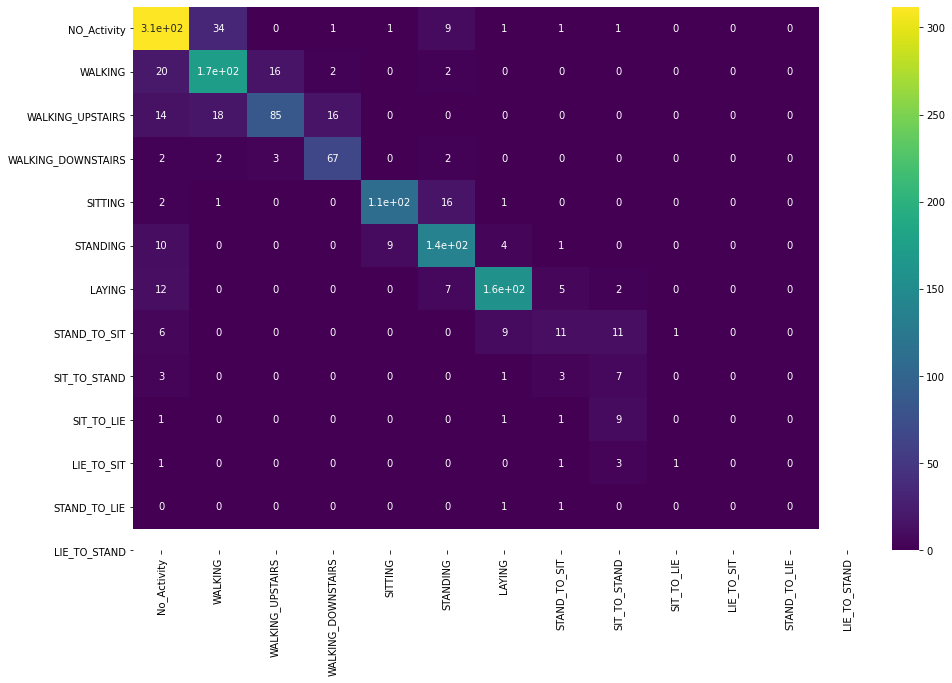

In [45]:
plt.figure(figsize=(16,10))
sns.heatmap(confusion_matrix(y_test,model.predict(X_test)), annot=True, cmap="viridis",
            xticklabels=["No_Activity","WALKING",
                       "WALKING_UPSTAIRS",
                       "WALKING_DOWNSTAIRS",
                       "SITTING",
                       "STANDING",
                       "LAYING",
                       "STAND_TO_SIT",
                       "SIT_TO_STAND",
                       "SIT_TO_LIE",
                       "LIE_TO_SIT",
                       "STAND_TO_LIE",
                       "LIE_TO_STAND"],
            yticklabels=['NO_Activity',"WALKING",
                       "WALKING_UPSTAIRS",
                       "WALKING_DOWNSTAIRS",
                       "SITTING",
                       "STANDING",
                       "LAYING",
                       "STAND_TO_SIT",
                       "SIT_TO_STAND",
                       "SIT_TO_LIE",
                       "LIE_TO_SIT",
                       "STAND_TO_LIE",
                       "LIE_TO_STAND"])

###  Saving the final model

In [27]:
import joblib

In [28]:
def save_model():
    '''Save the model to disk'''
    
    filename = '../models/har_model_v05.sav'
    joblib.dump(model, filename)
    readme = open('../models/ml_model_v05.txt', 'w')
    readme.write('Ml model with rfc, there is no overlapping in the original data. PSd have been calculated for the blocks and not for the activities the accuracy is less..')
    readme.close()

In [29]:
save_model()

In [30]:
features_to_drop

[('acc_x_FFT', 'peak_mean_6'),
 ('acc_x_FFT', 'peak_mean_8'),
 ('acc_x_FFT', 'peak_mean_12'),
 ('acc_y_FFT', 'peak_mean_6'),
 ('acc_y_FFT', 'peak_mean_8'),
 ('acc_y_FFT', 'peak_mean_12'),
 ('acc_z_FFT', 'peak_mean_6'),
 ('acc_z_FFT', 'peak_mean_8'),
 ('acc_z_FFT', 'peak_mean_12'),
 ('gyro_x_FFT', 'peak_mean_6'),
 ('gyro_x_FFT', 'peak_mean_8'),
 ('gyro_x_FFT', 'peak_mean_12'),
 ('gyro_y_FFT', 'peak_mean_6'),
 ('gyro_y_FFT', 'peak_mean_8'),
 ('gyro_y_FFT', 'peak_mean_12'),
 ('gyro_z_FFT', 'peak_mean_6'),
 ('gyro_z_FFT', 'peak_mean_8'),
 ('gyro_z_FFT', 'peak_mean_12')]